In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import time as tm
# import gsw as sw
from scipy.optimize import curve_fit
from scipy.stats import chi2
import gsw as sw
import numpy.ma as ma

from mpl_toolkits.basemap import Basemap, shiftgrid, cm
from netCDF4 import Dataset 



In [2]:
# import stations coordinate data
# set data directory 
indir = r'../data/'

infile = r'%snewmapping.csv' % indir
env = pd.read_csv(infile, sep = ',')

print env.columns
env['rho'] = sw.rho(env['S'], env['T'],0)

infile = '%sphi_data.csv' % indir
phi = pd.read_csv(infile, sep = ',')

# print phi['sample'], env['sample']
data = pd.merge(env, phi, on = 'sample')


Index([u'id', u'sample', u'lat', u'lon', u'T', u'S', u'CTD cast', u'Station',
       u'depth', u'eddy', u'nitrate', u'phosphate', u'silicic acid'],
      dtype='object')


In [3]:
# load the satellite NPP data

fname = '../data/satellite/A20141822014212.L3m_MO_CHL_chlor_a_4km.nc'
chl_data = Dataset(fname, mode='r')


chl = chl_data.variables['chlor_a']
lats = chl_data.variables['lat'][:]
lons = chl_data.variables['lon'][:]

lon, lat = np.meshgrid(lons, lats)

bad = (chl<0)
chla = np.ma.masked_where(bad, chl)

In [4]:
# import MDT data
infile = '../data/satellite/dt_global_allsat_msla_h_20140710_20150209.nc'
mdt_data = Dataset(infile, mode='r')

mdt_data.variables

mdt = np.squeeze(mdt_data.variables['sla'])
lats = mdt_data.variables['lat'][:]
lons = mdt_data.variables['lon'][:]

mdt,lons = shiftgrid(180.,mdt,lons,start=False)


# lons[lons>180] = lons[lons>180]-360

lon_mdt, lat_mdt = np.meshgrid(lons, lats)

# bad = (mdt<-3)
# mdta = np.ma.masked_where(bad, mdt)

# shift data so lons go from -180 to 180 instead of 20 to 380.


/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


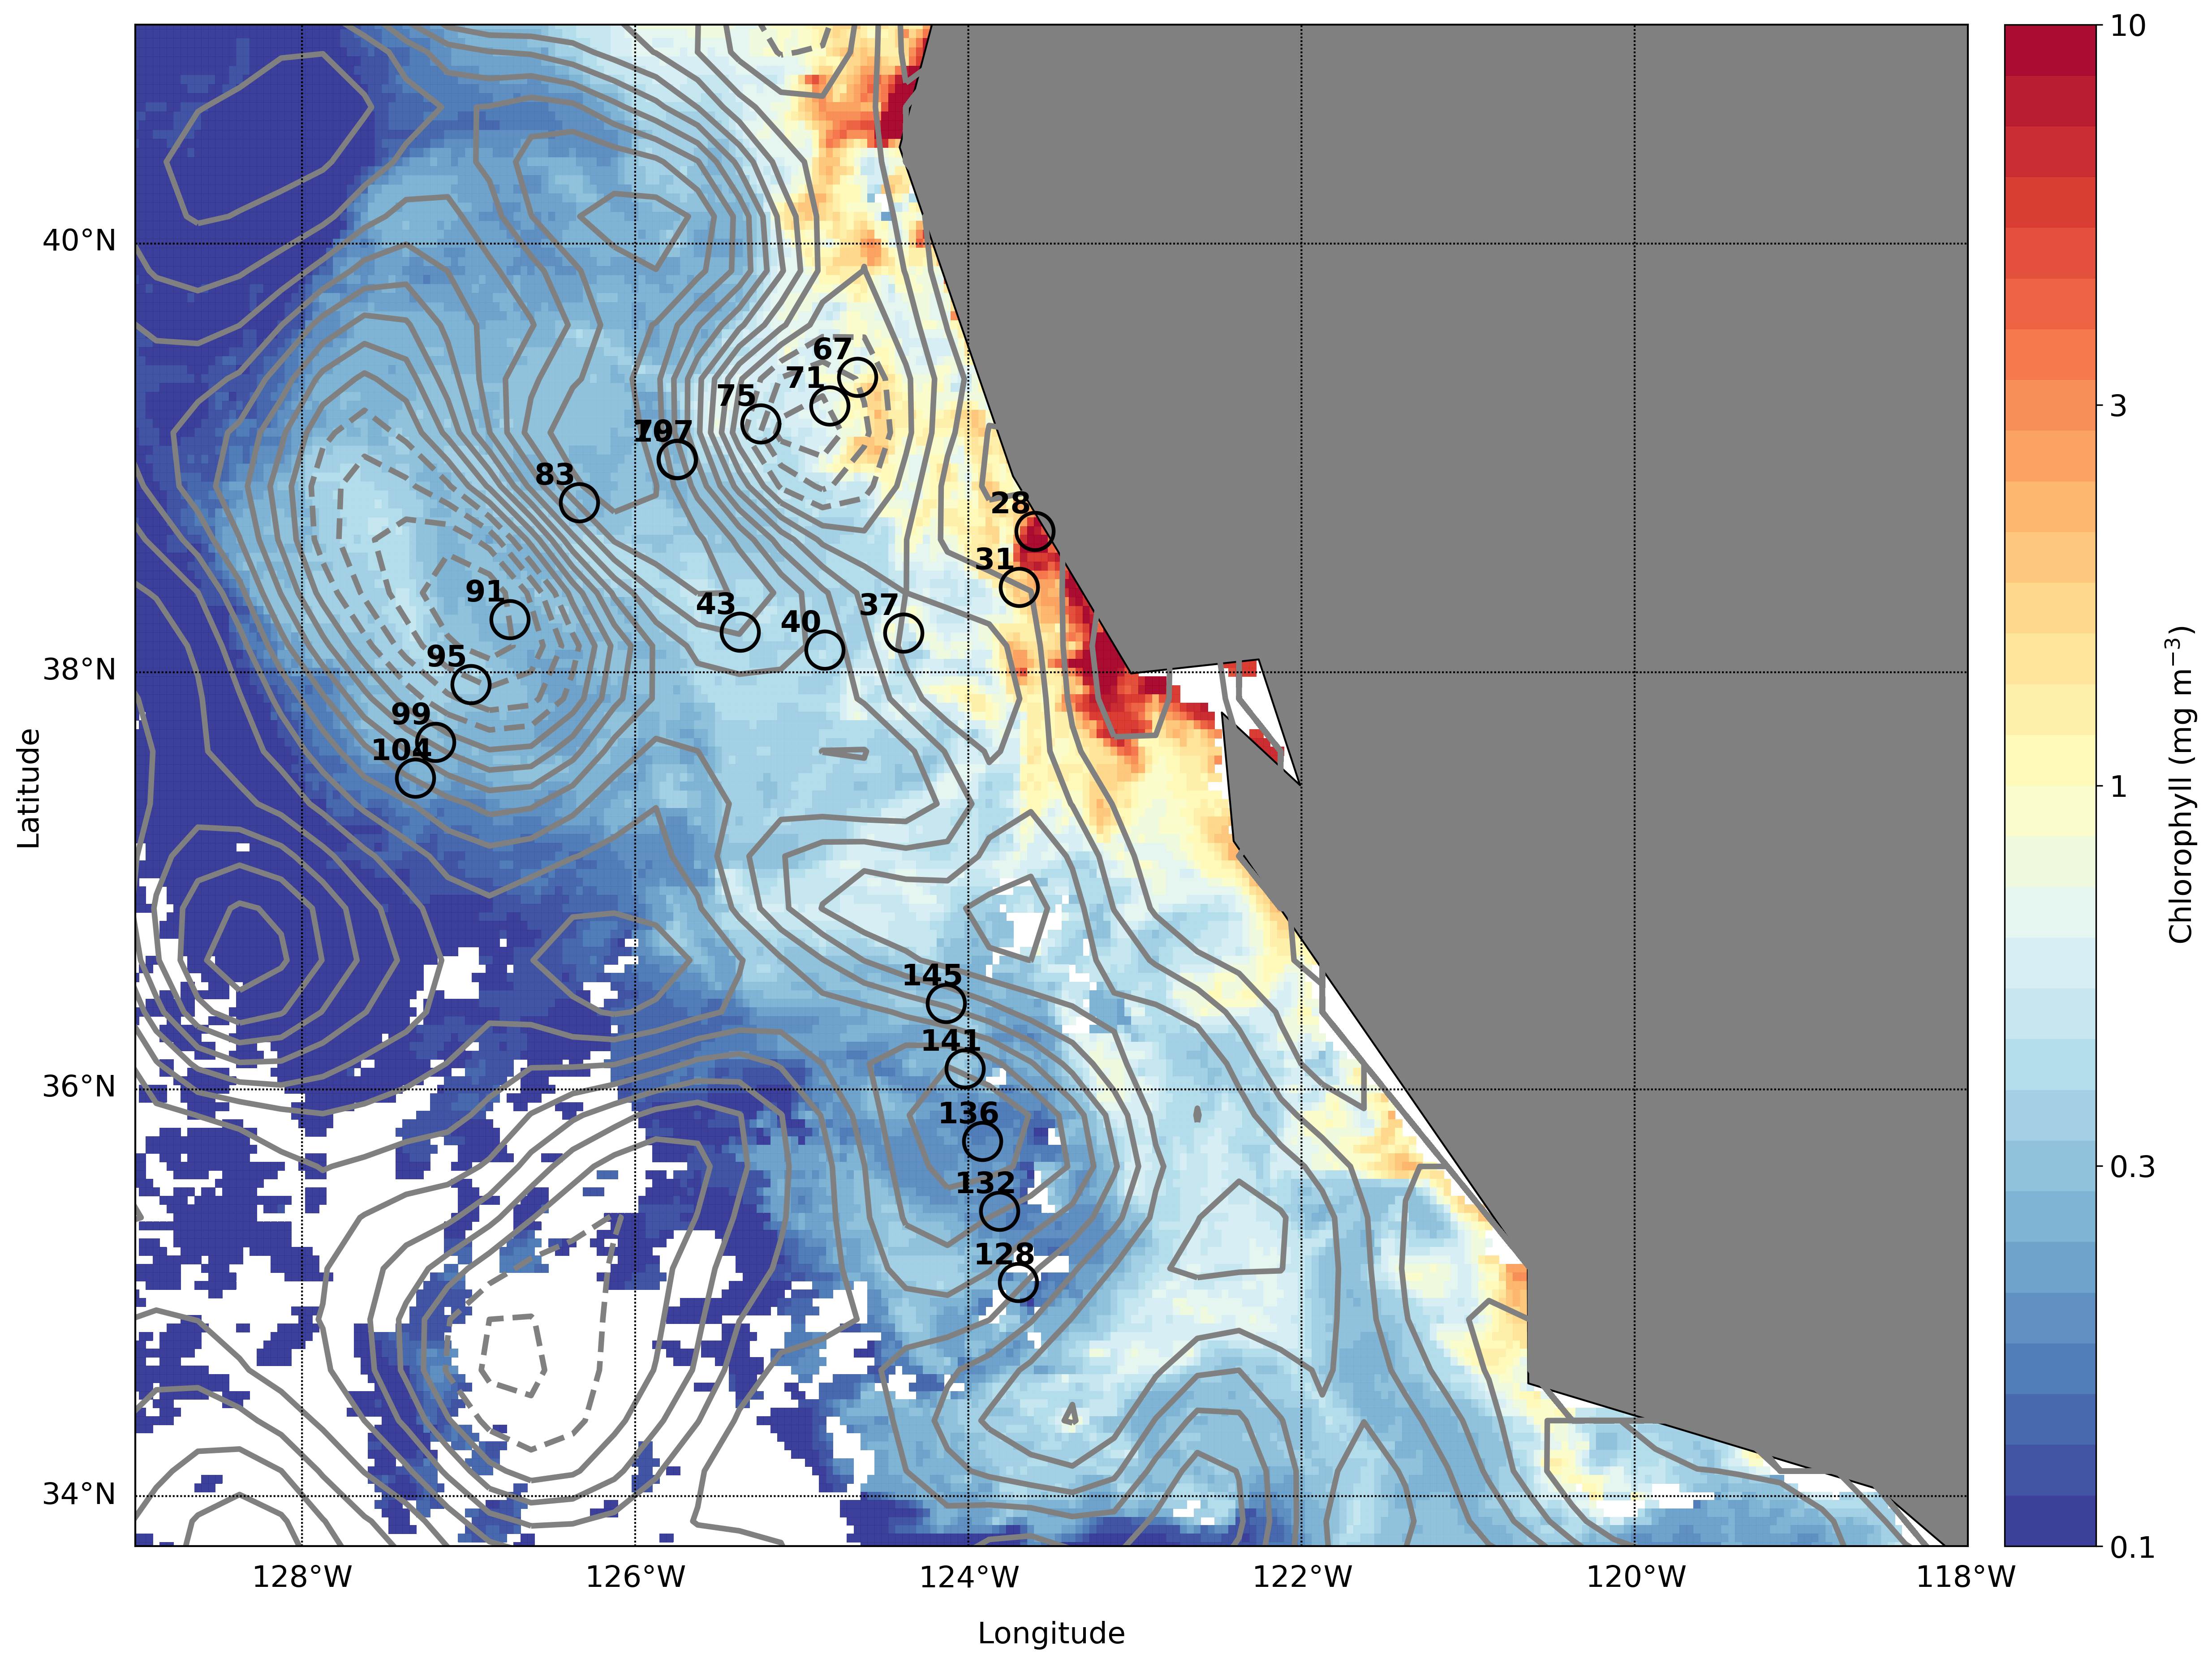

In [16]:
fig2,ax = plt.subplots(1, figsize=(20,15), dpi = 300)
palette = plt.get_cmap('RdYlBu_r', 30)
m = Basemap(projection='merc',llcrnrlat=33.75,urcrnrlat=41.,\
            llcrnrlon=-129,urcrnrlon=-118,lat_ts=0,resolution='c')
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')

# data = data[data['depth']<10]

xm, ym = m(data['lon'].values, data['lat'].values)
m.plot(xm,ym,'ok', markersize = 20, mfc='none', mew = 2)

n = data['sample']
for i, txt in enumerate(n):
    ax.annotate(txt, (xm[i]-30000,ym[i]+12000), fontsize = 16, fontweight = 'bold')

xc, yc = m(lon, lat)
CS1 = m.pcolormesh(xc, yc, np.log10(chl), shading='flat',cmap = palette, vmin = -1 , vmax = 1, zorder = 1, alpha = 0.95)

xii, yii = m(lon_mdt, lat_mdt)
# mm = m.contourf(xii,yii,mdt, cmap = mcon, vmin = -0.5, vmax = 1.75, lw = 3, zorder = 0, alpha = 0.5)
# m.colorbar(mm)

m.contour(xii,yii,mdt,levels = np.arange(-1,2, 0.025), colors = 'grey', linewidths = 3, zorder = 2, alpha = 1)

m.drawparallels(np.arange(-50,80,2),labels=[1,0,0,0], fontsize=16)
m.drawmeridians(np.arange(-180,180,2),labels=[0,0,0,1], fontsize=16)

cbar = m.colorbar(CS1, ticks = [-1, -0.5, 0, 0.5, 1])
cbar.set_ticklabels([0.1, 0.3, 1, 3, 10])
cbar.set_label(r'Chlorophyll (mg m$^{-3}$)', fontsize = 16)
cbar.ax.tick_params(labelsize = 16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 40)
plt.ylabel('Latitude', fontsize = 16, labelpad = 50)

fig2.savefig('../figures/cruise_map_hgt.png', dpi = 300)